### Your first hypervelocity star catalogue

`speedystar` is a python package which will allow you to generate, evolve, propagate and perform mock observations of single stars ejected at high velocities.

### Getting Started

Make sure this notebook is in the parent directory of `speedystar/`. The package itself is not large, but performing mock observations requires downloading a Milky Way dust map which by default is ~500 MB. This free space is assumed to be in the current working directory by default, but does not have to be (see below).

We currently do not recommend installing `speedystar` globally using pip since that prevents you from editing the source code directly.

`speedystar` uses a number of Python packages. Some of these which might not already be included in your Python distribution are astropy, galpy, mwdust and pygaia. Simply run this notebook and conda or pip install any package that doesn't exist.

More accurate treatments of the Gaia selection functions and astrometric spread function also require the Python packages scanninglaw and gaiaunlimited. These packages currently do not support Windows since they rely on the healpy package, but can be installed using Windows Subsystem for Linux (WSL).

### Documentation

help(speedystar.starsample) will display the names and descriptions of every method in `speedystar`, as well as descriptions of common column names.

### Outputs

`speedystar` outputs are .fits tables containing useful info for each mock star as well as metadata describing the assumptions that go into the sample. They can be accessed using astropy.table or with [Topcat](https://www.star.bris.ac.uk/~mbt/topcat/) or however else you'd like to read them.


In [1]:
#Import what you need
import numpy as np
import os
#os.chdir('/mnt/c/Users/frase/')
from speedystar import starsample
from speedystar.eject import Hills
from speedystar.utils.mwpotential import MWPotential
import astropy.units as u
from galpy import potential
import mwdust
from tqdm import tqdm
import matplotlib.pyplot as plt
#Print a lot of documentation
#help(starsample)

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(



In [2]:
potential = MWPotential()

In [5]:
from galpy.util.conversion import get_physical

In [6]:
get_physical(potential)['vo']*u.km/u.s

<Quantity 220.0 km / s>

In [7]:
get_physical(potential)['ro']*u.kpc

<Quantity 8.0 kpc>

### Ejecting a sample

We're now ready to eject some stars!

The 'typical' way to eject hypervelocity stars is via the Hills Mechanism, in which a stellar binary approaches Sgr A* on a very low-angular momentum orbit. At a particular distance from Sgr A*, the tidal forces across the binary surpass the gravitational binding energy of the binary itself and the binary is separated. One star is captured in orbit around Sgr A* and the other is flung away at a velocities up to several thousand km/s. Stars ejected above the escape velocity of the Galaxy are hypervelocity stars (HVSs) -- they will eventually escape the Galaxy entirely. Note that there will also be a population of stars ejected slowly as well, which will not escape the inner Galaxy and might survive to interact again with Sgr A*.

<p align="center">
<img src ="https://www.universetoday.com/wp-content/uploads/2023/01/hills-mechanism.jpg" width="50%" height="50%">
</p>

With `speedystar` you first generate a sample of stars at the moment of ejection. The number of stars and their masses/metallicities/velocities/flight times/evolutionary stages depend a lot on assumptions you make about stars and binaries in the Galactic Centre, see [Evans+2022](https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.2350E/abstract) for more details.


## Build a simple catalog

In [2]:
simulated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/speedystar/simulated_catalogs/new/evolved'

In [11]:
#  the mass of Sgr A*, the maximum flight time, etc.

#simulated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/speedystar/simulated_catalogs/top_heavy'
ejectionmodel = Hills(rate=1e-4/u.yr, amuseflag= True, Met= 0)
mysample = starsample(ejectionmodel, name='sill_copy')
#mysample.save(os.path.join(simulated_catalogs_path, f'cat_ejection_kappa_{1.7}.fits'))

Evolving HVSs:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/mncavieres/opt/anaconda3/envs/speedytest2/lib/python3.12/site-packages/amuse/rfi/core.py:964: UserWarning: MPI (unexpectedly?) not available, falling back to sockets channel
  warnings.warn("MPI (unexpectedly?) not available, falling back to sockets channel")



Evolving HVSs: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


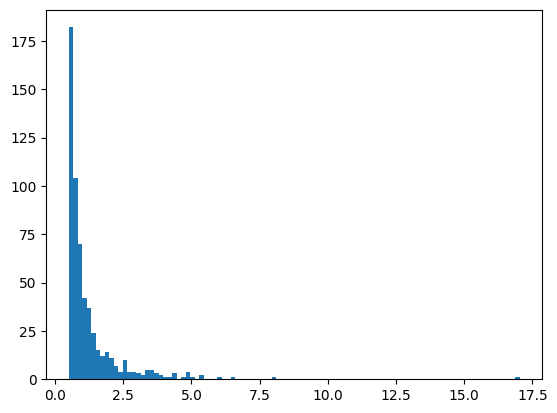

In [5]:
plt.hist(mysample.m, bins = 100)
plt.show()

## Build for a range of IMF slopes

In [ ]:
#Current ejection methods include 'Hills' implementing the Hills mechanism
#  and 'BMBH' implementing the massive black hole binary slingshot mechanism

# Arguments to Hills() allow you to set many parameters for the sample, e.g. the stellar initial mass function,
#  the mass of Sgr A*, the maximum flight time, etc.

simulated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/speedystar/simulated_catalogs/top_heavy'
kappa_range = np.linspace(1, 2.5, 10)
for kappa in kappa_range:
    ejectionmodel = Hills(rate=1e-4/u.yr, kappa=kappa, amuseflag= True, Met= 0.25)
    mysample = starsample(ejectionmodel, name='sill_copy')
    mysample.save(os.path.join(simulated_catalogs_path, f'cat_ejection_kappa_{kappa}.fits'))

In [ ]:
# just generate a lot of stars with flat IMF to the apply importance sampling
#  the mass of Sgr A*, the maximum flight time, etc.
simulated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/top_heavy_Lu_2013/sample'

for kappa in tqdm(range(200)):
    ejectionmodel = Hills(rate=1e-3/u.yr, amuseflag= True, Met= 0.02, kappa=1.7)
    mysample = starsample(ejectionmodel, name='sill_copy')
    mysample.save(os.path.join(simulated_catalogs_path, f'cat_ejection_{kappa}.fits'))

# ejectionmodel = Hills(rate=1e-1/u.yr, kappa=1.7, amuseflag= True, Met= 0.25)
# mysample = starsample(ejectionmodel, name='sill_copy')
# mysample.save(os.path.join(simulated_catalogs_path, f'cat_ejection_kappa_{1.7}.fits'))

### Propagating the sample

The 'ejection sample' consists of a population of stars freshly ejected from the centre of the Milky Way. Next we have to propagate them through the Galaxy (each at its own assigned flight time) to find out where they will be at the present day. To do this we will have to assume a potential for the Galaxy. 

<p align="center">
<img src ="https://cdn.sci.news/images/enlarge4/image_5003e-Hypervelocity-Stars.jpg" width="50%" height="50%">
</p>


In [19]:
propagated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/top_heavy_Lu_2013/propagated'

#simulated_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/speedystar/simulated_catalogs/top_heavy'

# Assume a Galactic potential
default_potential = MWPotential()
#Ensure the potential has physical units so that the final positions and velocities have physical units too
potential.turn_physical_on(default_potential)

for catalog in tqdm(os.listdir(simulated_catalogs_path)):
    # Skip already propagated samples
    if os.path.isfile(os.path.join(simulated_catalogs_path, catalog)):
        pass
    # Only propagate FITS files
    if catalog.endswith('.fits'):
            # Load ejection sample, if it doesn't already exist
        mysample = starsample(os.path.join(simulated_catalogs_path, catalog))

        #Propagate sample. Positions / velocities are returned in Cartesian (x/y/z/v_x/v_y/v_z) and Galactic (l/b/dist/pm_l/pm_b/v_radial) and equatorial (ra/dec/dist/pm_ra/pm_dec/v_radial) coordinates
        mysample.propagate(potential = default_potential)

        #Save propagated sample
        mysample.save(os.path.join(propagated_catalogs_path, catalog))

100%|██████████| 200/200 [27:16:17<00:00, 490.89s/it]


### Subsetting the catalogue

So far we've ejected and propagated everything, including fast and slow stars. If we're only interested in the hypervelocity stars, we can use boolean indexing on a speedystar object.

In [13]:
fast = mysample.GCv > mysample.Vesc

print('Size of the entire sample: '+str(mysample.size))

mysample = mysample[fast]
print('Size of the fast sample: '+str(mysample.size))

Size of the entire sample: 561
Size of the fast sample: 424


### Mock observations of the sample

We next have to figure out how bright each of the stars is, otherwise we don't know which of the stars would be detectable today or in the near future. `speedystar` is able to calculate the apparent magnitudes of the sample in a variety of photometric bassbands (e.g. Gaia G/G_BP/G_RP/G_RVS, Johnson-Cousins UBVRI, SDSS/LSST ugriz, VISTA JHK) depending on the mass, temperature and radius of the stars along with their distance and position on the sky.



In [ ]:
photometric_catalogs_path = '/Users/mncavieres/Documents/2024-2/HVS/Data/speedystar_catalogs/stock/phot_prop'

for catalog in tqdm(os.listdir(propagated_catalogs_path)):
    # Only compute actual catalogs FITS files
    if not catalog.endswith('.fits'):
        print('Skipping', catalog)
        continue

    # Load propagated sample
    mysample = starsample(os.path.join(propagated_catalogs_path, catalog))

    # Select only HVSs that are fast
    fast = mysample.GCv > 300
    mysample = mysample[fast]
    
    #Assign the dust map. Will be downloaded if it doesn't already exist in the working directory or where you've
    #   specified above
    mysample.dust = mwdust.Combined15()

    #Get mock apparent magnitudes . By default magnitudes are computed in the Johnson-Cousins V and I bands 
    #   and the Gaia G, G_RP, G_BP and G_RVS bands.
    #   By default this also returns Gaia astrometric and radial velocity errors assuming Gaia DR4 precision
    mysample.photometry()

    #Save the sample with mock photometry
    mysample.save(os.path.join(photometric_catalogs_path, catalog))

100%|██████████| 100/100 [37:20<00:00, 22.41s/it]


In [14]:
#Load a pre-existing propagated sample, if needed
mysample = starsample('./cat_propagated.fits')

#Magnitudes are exctincted by Milky Way dust along the line of sight. Need to assign a dust map. 
#Dust map(s) must be downloaded if they do not already exist. They can be rather large, ~500 MB.

#Uncomment this line and fill out a path if the dust map is located somewhere other than the working
#   directory, or you want it downloaded somewhere other than the working directory
#mysample.config_dust('/path/to/where/you/want/the/dust/map')

#Assign the dust map. Will be downloaded if it doesn't already exist in the working directory or where you've
#   specified above
mysample.dust = mwdust.Combined15()

#Get mock apparent magnitudes . By default magnitudes are computed in the Johnson-Cousins V and I bands 
#   and the Gaia G, G_RP, G_BP and G_RVS bands.
#   By default this also returns Gaia astrometric and radial velocity errors assuming Gaia DR4 precision
mysample.photometry()

#Save the sample with mock photometry
mysample.save('./cat_photometry.fits')

Calculating magnitudes: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


### Gaia detectability
 Finally, let's determine which stars would be detectable in Gaia Data Release 3.
 
 Gaia magnitude cuts can be performed using mysample[...], but they're also implemented directly in `speedystar.subsample` for simplicity, along with some other common cuts. These cuts will also automatically calculate DR3 mock Gaia errors.


In [15]:
detectable_dr3_path = '/Users/mncavieres/Documents/2024-2/HVS/speedystar/simulated_catalogs/detectable_DR3'

for catalog in tqdm.tqdm(os.listdir(photometric_catalogs_path)):
    if not catalog.endswith('.fits'):
        pass
    # Load photometric sample
    mysample = starsample(os.path.join(photometric_catalogs_path, catalog))

    #Determine which stars would be in principle detectable in Gaia DR3 and recalculate errors
    mysample.subsample('Gaia_DR3')

    #Save the cut sample
    mysample.save(os.path.join(detectable_dr3_path, catalog))

100%|██████████| 100/100 [00:10<00:00,  9.95it/s]


In [15]:
#Load a pre-existing sample with photometry, if needed
mysample = starsample('./cat_photometry.fits')

#Determine which stars would be in principle detectable in Gaia DR3 and recalculate errors
mysample.subsample('Gaia_DR3')

#Save the cut sample
mysample.save('./cat_gaiaDR3.fits')
print('Number of stars in Gaia DR3: '+str(mysample.size))

#Determine which stars would be in principle detectable in the subsample of Gaia DR4 with
#   measured radial velocities.
mysample.subsample('Gaia_6D_DR4')

#Save the cut sample
mysample.save('./cat_gaiaDR4_6D.fits')
print('Number of stars in Gaia DR4 with radial velocity: '+str(mysample.size))


Number of stars in Gaia DR3: 95
Number of stars in Gaia DR4 with radial velocity: 4


In [17]:
#Load a pre-existing sample with photometry, if needed
mysample = starsample('./cat_photometry.fits')
mysample.subsample('Gaia_DR4')

#Save the cut sample
mysample.save('./cat_gaiaDR4.fits')
print('Number of stars in Gaia DR4: '+str(mysample.size))

Number of stars in Gaia DR4: 95


In [20]:
#Load a pre-existing sample with photometry, if needed
mysample = starsample('./cat_photometry.fits')
mysample.subsample('Gaia_6D_DR4')
print('Number of stars in Gaia DR4: '+str(mysample.size))

Number of stars in Gaia DR4: 4
